In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('final_df.csv')
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,PACK_SIZE,BRAND,MONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,Natural,10
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,CCs,5
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,Smiths,5
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,175,Smiths,8
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget,150,Kettle,8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264833 entries, 0 to 264832
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              264833 non-null  object 
 1   STORE_NBR         264833 non-null  int64  
 2   LYLTY_CARD_NBR    264833 non-null  int64  
 3   TXN_ID            264833 non-null  int64  
 4   PROD_NBR          264833 non-null  int64  
 5   PROD_NAME         264833 non-null  object 
 6   PROD_QTY          264833 non-null  int64  
 7   TOT_SALES         264833 non-null  float64
 8   LIFESTAGE         264833 non-null  object 
 9   PREMIUM_CUSTOMER  264833 non-null  object 
 10  PACK_SIZE         264833 non-null  int64  
 11  BRAND             264833 non-null  object 
 12  MONTH             264833 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 26.3+ MB


In [5]:
# Now we need to filter for stores that have transactions in every month of the experiment's 12 month
# Group by store number and count unique months for each store
monthly_counts = df.groupby('STORE_NBR')['MONTH'].nunique()
valid_stores = monthly_counts == 12
# Map this boolean series back to the original dataframe
df['valid_control_store'] = df['STORE_NBR'].map(valid_stores)
valid_control_stores = df.loc[df['valid_control_store']==True]['STORE_NBR'].unique()

In [6]:
trial_stores = df.loc[df['STORE_NBR'].isin([77, 86, 88])]
control_stores = df.loc[(df['STORE_NBR'].isin(valid_control_stores)) & (~df['STORE_NBR'].isin([77, 86, 88]))]
trial_stores_before_feb = trial_stores.loc[trial_stores['DATE'] < '2019-02-01']
control_stores_before_feb = control_stores.loc[control_stores['DATE'] < '2019-02-01']
df_before_feb = df.loc[df['DATE'] < '2019-02-01']
trial_stores_trial_period = trial_stores.loc[(trial_stores['DATE'] >= '2019-02-01') & (trial_stores['DATE'] < '2019-04-01')]
control_stores_trial_period = control_stores.loc[(control_stores['DATE'] >= '2019-02-01') & (control_stores['DATE'] < '2019-04-01')]
df_trial_period = df.loc[(df['DATE'] >= '2019-02-01') & (df['DATE'] < '2019-04-01')]

In [7]:
# Metrics to compare store performances
def make_pivot_table(df):
        
    pivot_table = pd.pivot_table(
        df,
        index=['MONTH', 'STORE_NBR'],
        values=['TOT_SALES', 'LYLTY_CARD_NBR', 'TXN_ID'],
        aggfunc={
            'TOT_SALES': 'sum',                   # Monthly overall sales revenue
            'LYLTY_CARD_NBR': pd.Series.nunique,  # Monthly number of customers
            'TXN_ID': 'count'                     # Monthly number of transactions
        }
    )

    # Calculate the monthly number of transactions per customer
    pivot_table['Avg_Transactions_Per_Customer'] = pivot_table['TXN_ID'] / pivot_table['LYLTY_CARD_NBR']

    # Rename the columns for clarity
    pivot_table.rename(columns={
        'TOT_SALES': 'Monthly_Sales_Revenue',
        'LYLTY_CARD_NBR': 'Monthly_Customers',
        'TXN_ID': 'Monthly_Transactions'
    }, inplace=True)

    # Reset index to make it easier to read
    pivot_table.reset_index(inplace=True)
    return pivot_table


In [8]:
# Creating pivot tables to match similarity
pre_feb_df_metrics = make_pivot_table(df_before_feb)
trial_period_metrcis = make_pivot_table(df_trial_period)

In [9]:
# then find the hieghest correlated control store with each trial store
pre_feb_df_metrics.head()

,MONTH,STORE_NBR,Monthly_Customers,Monthly_Sales_Revenue,Monthly_Transactions,Avg_Transactions_Per_Customer
0,1,1,35,154.8,36,1.028571
1,1,2,43,162.8,45,1.046512
2,1,3,102,1051.7,121,1.186275
3,1,4,134,1525.0,168,1.253731
4,1,5,92,838.0,118,1.282609


In [10]:
# from sklearn.preprocessing import StandardScaler
# from dtaidistance import dtw

# # Standardize the data
# scaler = StandardScaler()
# pre_feb_trial_metrics[['Monthly_Customers', 'Monthly_Sales_Revenue', 'Monthly_Transactions']] = scaler.fit_transform(pre_feb_trial_metrics[['Monthly_Customers', 'Monthly_Sales_Revenue', 'Monthly_Transactions']])
# pre_feb_control_metrics[['Monthly_Customers', 'Monthly_Sales_Revenue', 'Monthly_Transactions']] = scaler.fit_transform(pre_feb_control_metrics[['Monthly_Customers', 'Monthly_Sales_Revenue', 'Monthly_Transactions']])

# # Function to calculate DTW distance
# def calculate_dtw(trial_store, control_store):
#     distances = []
#     for feature in ['Monthly_Customers', 'Monthly_Sales_Revenue', 'Monthly_Transactions']:
#         distance = dtw.distance(trial_store[feature].values, control_store[feature].values)
#         distances.append(distance)
#     return sum(distances)

# # Find the closest control store for each trial store
# closest_stores = {}
# for trial_id in pre_feb_trial_metrics['STORE_NBR'].unique():
#     trial_store_data = pre_feb_trial_metrics[pre_feb_trial_metrics['STORE_NBR'] == trial_id]
#     min_distance = float('inf')
#     closest_store = None
#     for control_id in pre_feb_control_metrics['STORE_NBR'].unique():
#         control_store_data = pre_feb_control_metrics[pre_feb_control_metrics['STORE_NBR'] == control_id]
#         distance = calculate_dtw(trial_store_data, control_store_data)
#         if distance < min_distance:
#             min_distance = distance
#             closest_store = control_id
#     closest_stores[trial_id] = closest_store

# print("Closest Store Pairs:", closest_stores)



In [11]:
# import numpy as np

# def calculate_magnitude_distance(input_table, metric_col, store_comparison):
#     calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
#     store_numbers = input_table['STORE_NBR'].unique()

#     for i in store_numbers:
#         if i != store_comparison:
#             calculated_measure = pd.DataFrame({
#                 'Store1': [store_comparison] * len(input_table[input_table['STORE_NBR'] == store_comparison]),
#                 'Store2': [i] * len(input_table[input_table['STORE_NBR'] == store_comparison]),
#                 'YEARMONTH': input_table[input_table['STORE_NBR'] == store_comparison]['MONTH'].values,
#                 'measure': np.abs(
#                     input_table[input_table['STORE_NBR'] == store_comparison][metric_col].values -
#                     input_table[input_table['STORE_NBR'] == i][metric_col].values
#                 )
#             })
#             calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

#     # Standardize the magnitude distance so that the measure ranges from 0 to 1
#     min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
#     min_max_dist.columns = ['Store1', 'YEARMONTH', 'minDist', 'maxDist']
#     dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
#     dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['minDist']) / (dist_table['maxDist'] - dist_table['minDist'])

#     final_dist_table = dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
#     final_dist_table.columns = ['Store1', 'Store2', 'mag_measure']

#     return final_dist_table

# corr_df = calculate_magnitude_distance(pre_feb_df_metrics, 'Monthly_Sales_Revenue', 77)


### Now that we have selected our control stores, let's compare pairwise performance during the pre-trial period

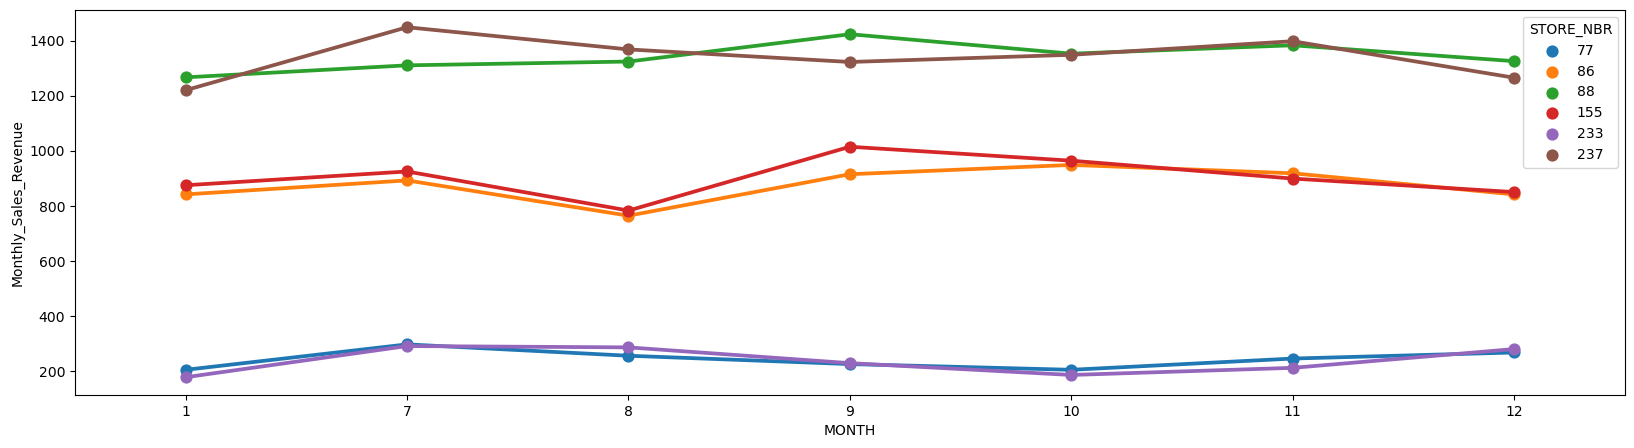

In [12]:
exp_stores = [77, 86, 88, 233, 155, 237]
plt.figure(figsize=(20, 5))
sns.pointplot(x='MONTH', y='Monthly_Sales_Revenue', data=pre_feb_df_metrics[pre_feb_df_metrics['STORE_NBR'].isin(exp_stores)], estimator=sum, errorbar=None, hue='STORE_NBR')
plt.show()

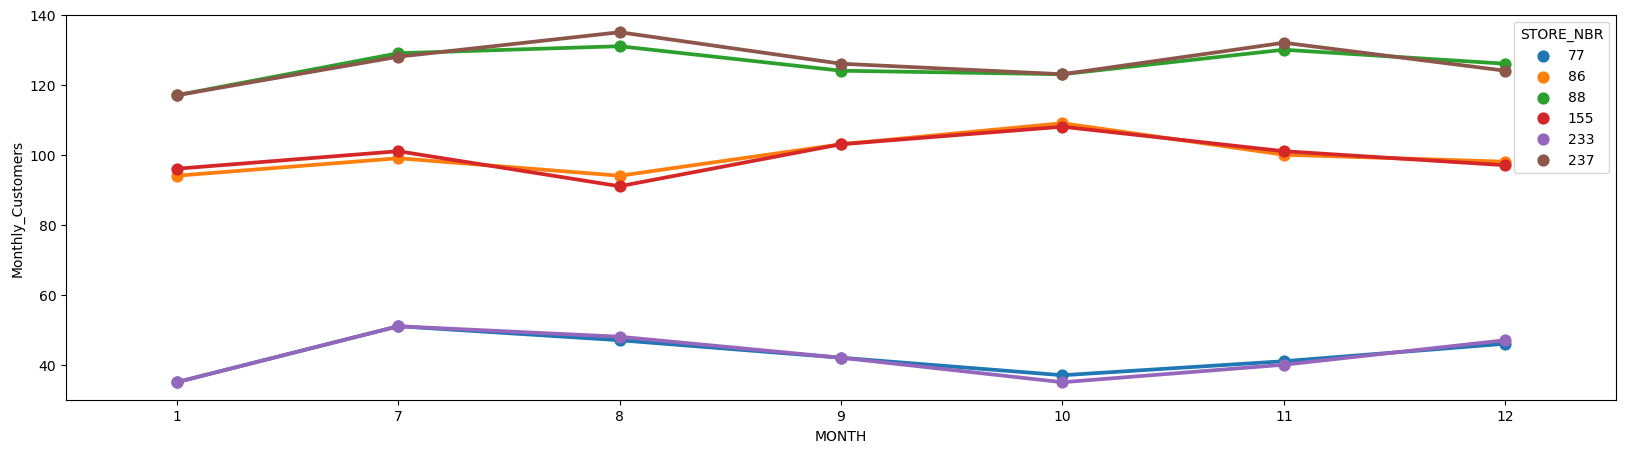

In [13]:

plt.figure(figsize=(20, 5))
sns.pointplot(x='MONTH', y='Monthly_Customers', data=pre_feb_df_metrics[pre_feb_df_metrics['STORE_NBR'].isin(exp_stores)], estimator=sum, errorbar=None, hue='STORE_NBR')
plt.show()

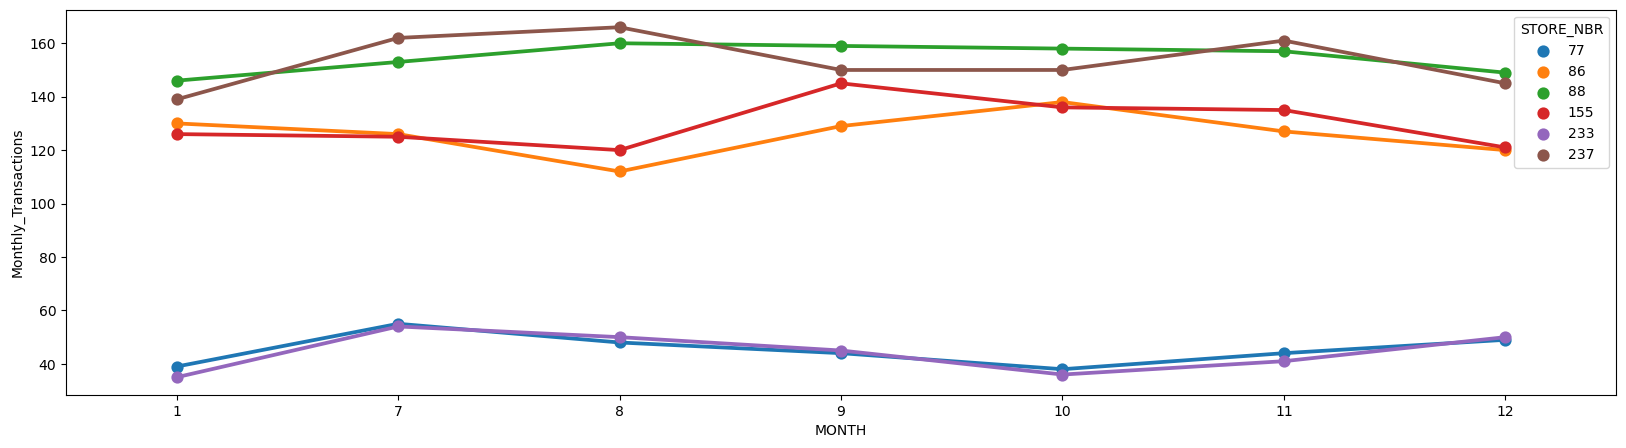

In [14]:
plt.figure(figsize=(20, 5))
sns.pointplot(x='MONTH', y='Monthly_Transactions', data=pre_feb_df_metrics[pre_feb_df_metrics['STORE_NBR'].isin(exp_stores)], estimator=sum, errorbar=None, hue='STORE_NBR')
plt.show()

### We can see that the control stores are indeed performing very similarly to the selected trial tores

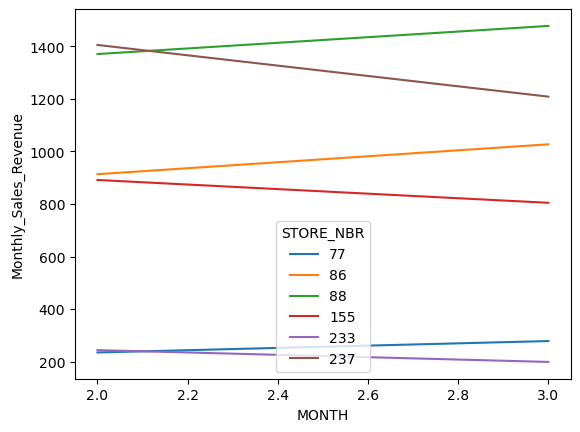

In [26]:
# Now let's visually check the effect of the new layout on the performance
sns.lineplot(x='MONTH', y='Monthly_Sales_Revenue', data=trial_period_metrcis[trial_period_metrcis['STORE_NBR'].isin(exp_stores)], hue='STORE_NBR', palette='tab10', estimator=sum)
plt.show()

# from the graph, it appears there's a noticable difference in performace after applying
# the new product layout in stores 86, 88 but an insignificant diffrence in store 77